# Create the Multispectral Input Tensor

## Load the Necessary Libraries

In [163]:
import random
import numpy as np
from datasets import load_dataset

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import albumentations as A
from albumentations.pytorch import ToTensorV2

BATCH_SIZE = 256
WIDTH = 360
HEIGHT = 480

## Define Constants

In [260]:
random.seed(42)
np.random.seed(42)
torch.random.seed()

AVAILABLE_3CH = [
    "RGB",
    "CIR"
]


AVAILABLE_1CH = [
    "R",
    "G",
    "B",
    "NIR",
    "RE",
    "NDVI",
]

TOTAL_CHANNELS = ["B", "CIR", "G", "NDVI", "NIR", "R", "RE", "RGB"]


transformations = A.Compose(
    [
        A.RandomCrop(width=256, height=256),
        ToTensorV2()
    ],
    additional_targets={
        'RGB': 'image', 
        'CIR': 'image',
        'R': 'image',
        'G': 'image',
        'B': 'image',
        'NDVI': 'image',
        'NIR': 'image',
        'RE': 'image'
    }
)


## Define the neccesary functions

In [269]:
def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):

   img = np.array(image) * 0.7 + mask * 0.4  # plot the image with the segmentation map
   img = img.astype(np.uint8)

   plt.figure(figsize=(15, 10))
   plt.imshow(img, alpha=0.7)
   plt.axis("off")
   plt.show()

def list_of_dicts(dict_of_list):
    list_of_dicts = map(dict, zip(*[[(key, val) for val in value] for key, value in dict_of_list.items()]))
    return list(list_of_dicts)

def transforms_deprecated(examples):
    for index, channel in enumerate(TOTAL_CHANNELS):
        transformed_images, transformed_masks = [], []
        
        for image, seg_mask in zip(examples[channel], examples["annotation"]):

            seg_mask = seg_mask.convert("RGB")
            image, seg_mask = np.array(image), np.array(seg_mask)

            transformed = transform(image=image, mask=seg_mask)
            transformed_images.append(transformed["image"].permute(1, 2, 0))
            transformed_masks.append(transformed["mask"])

        examples[channel] = transformed_images

        if index == 0:
            examples["label"] = transformed_masks
    
    return examples

def transforms(examples):

    transformed_multispectrals, transformed_masks = [], []

    for observation in list_of_dicts(examples):
        seg_mask = np.array(observation["annotation"])
        image_RGB = np.array(observation["RGB"])
        image_CIR = np.array(observation["CIR"])
        image_R = np.array(observation["R"])
        image_G = np.array(observation["G"])
        image_B = np.array(observation["B"])
        image_NDVI = np.array(observation["NDVI"])
        image_NIR = np.array(observation["NIR"])
        image_RE = np.array(observation["RE"])

        transformed = transformations(
            image=image_RGB,
            mask = seg_mask,
            RGB = image_RGB,
            CIR = image_CIR,
            R = image_R,
            G = image_G,
            B = image_B,
            NDVI = image_NDVI,
            NIR = image_NIR,
            RE = image_RE
        )


        multispectral = torch.cat([transformed[channel].permute(1, 2, 0) for channel in INPUT_CHANNELS], dim=2)
        
        transformed_multispectrals.append(multispectral)
        transformed_masks.append(transformed["mask"])
    
    examples["multispectral"] = transformed_multispectrals
    examples["label"] = transformed_masks

    return examples

## Huggingface Multispectral Image Dataset Preprocessing

### Loading  the dataset, deleting empty masks and concatenate the bands of interest

In [273]:
# STEP1: load the dataset
red_edge_dataset = load_dataset("viarias/remote_sensing_2018_weedmap", "red_edge", trust_remote_code=True)

# STEP2: filtering the masks with not useful information
red_edge_dataset_filter = red_edge_dataset.filter(lambda example: example["annotation"].getbbox())


# STEP3: define the multispectral input image channels and apply the transformation
INPUT_CHANNELS = [
      "RGB",
      "NIR",
      "RE",
]

red_edge_dataset_filter.set_transform(transforms)

#

### Plot one Example

torch.Size([256, 256, 5])
torch.Size([256, 256, 3])


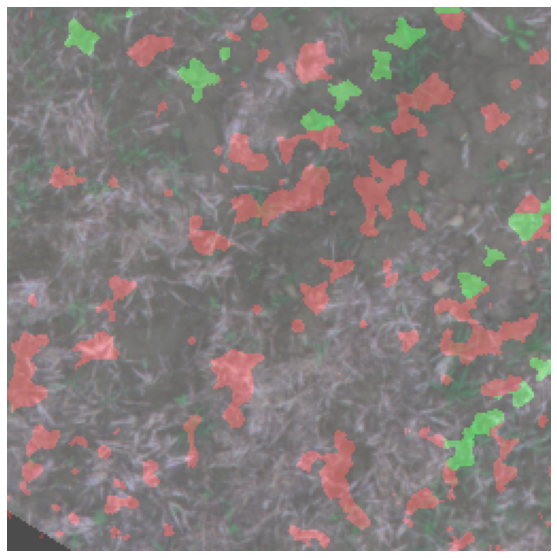

In [272]:
print(red_edge_dataset_filter["train"][0]["multispectral"].shape)
print(red_edge_dataset_filter["train"][0]["label"].shape)

index = 100

visualize_seg_mask(
    np.array(red_edge_dataset_filter["train"][index]["multispectral"][:,:,:3]),
    np.array(red_edge_dataset_filter["train"][index]["label"])
)